# Wall of imports

In [1]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import pandas as pd

import numpy as np

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
%matplotlib widget

from tqdm import tqdm

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Normalizer

RANDOM_SEED = None

from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.linalg import Vectors

from functools import reduce

import json

from pyspark.ml.regression import LinearRegression

from pyspark_dist_explore import hist

from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml import Pipeline

from pyspark.ml.tuning import ParamGridBuilder

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import GBTRegressor

from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from operator import itemgetter

from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.linalg import Vectors, VectorUDT

from pyspark.ml.stat import Summarizer

from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA

from pyspark.ml.feature import UnivariateFeatureSelector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import FunctionTransformer


import warnings # supress warnings
warnings.filterwarnings('ignore')

# Spark

In [2]:
conf = (
    SparkConf()
    .set("spark.ui.port", "4050")
    .set("spark.executor.memory", "4G")
    .set("spark.driver.memory", "20G")
    .set("spark.driver.maxResultSize", "10G")
)
# .set("spark.master", "spark://192.168.1.189:4050")


# create the context
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")


spark = SparkSession.builder.getOrCreate()

22/06/12 09:37:56 WARN Utils: Your hostname, RTX-2070-Rig resolves to a loopback address: 127.0.1.1; using 192.168.1.189 instead (on interface wlp7s0)
22/06/12 09:37:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/12 09:37:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading football players

In [3]:
modern_df = spark.read.csv(
    "data/players_*.csv", sep=",", inferSchema=True, header=True, multiLine=True
)

legacy_df = spark.read.csv(
    "data/scraped_players_*.csv", sep=",", inferSchema=True, header=True, 
    multiLine=True
)

# Pre-processing football players

In [4]:
leagues = [
    "Spain Primera Division",
    # "German 1. Bundesliga",
    # "French Ligue 1",
    # "English Premier League",
    # "Italian Serie A",
    # "Holland Eredivisie",
]

# seasons_modern = ["20", "19", "18", "17", "16", "15", "14"] 
seasons_modern = ["20"] 
# seasons_legacy = ["13", "12", "11", "10", "09", "08", "07"]
seasons_legacy = [ "13" ]
seasons = seasons_legacy + seasons_modern

# football_teams = [
#     row["club_name"] for row in modern_df.select(
#         "club_name"
#     ).distinct().collect()
# ]

columns = [
    "short_name",
    "club_name",
    "league_name",
    "season",
    "player_positions",
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

def get_season(url):
    url_split = url.split("/")

    # -1 to scale FIFA years down, to have compatibility with all_tables_fixed
    return str(
        (int(url_split[-2 if url_split[-1] == "" else -1][0:2]) - 1)
    ).zfill(2)


get_season_UDF = udf(lambda url: get_season(url), StringType())

roles_to_macro_role_UDF = udf(
    lambda roles: float(roles_to_macro_roles_dict[roles.split(",")[0]]), StringType()
)

In [5]:
pre_processed_modern_df = modern_df.dropDuplicates(["player_url"])
pre_processed_legacy_df = legacy_df.dropDuplicates(["player_url"])

pre_processed_modern_df = pre_processed_modern_df.na.fill(0)
pre_processed_legacy_df = pre_processed_legacy_df.na.fill(0)

pre_processed_modern_df = pre_processed_modern_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)

pre_processed_modern_df = pre_processed_modern_df.withColumnRenamed(
    "value_eur", "value"
)

pre_processed_modern_df = pre_processed_modern_df.where(
    (pre_processed_modern_df.league_name.isin(leagues))
    &
    (pre_processed_modern_df.season.isin(seasons_modern))
)
pre_processed_legacy_df = pre_processed_legacy_df.where(
    (pre_processed_legacy_df.league_name.isin(leagues))
    &
    (pre_processed_legacy_df.season.isin(seasons_legacy))
)

pre_processed_modern_df = pre_processed_modern_df.select(columns)

# TODO use a for loop
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pas", "passing"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "dri", "dribbling"
)
pre_processed_legacy_df = pre_processed_legacy_df.drop(col("defending"))

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "def", "defending"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "phy", "physic"
)

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "sho", "shooting"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pac", "pace"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "bov", "overall"
)

pre_processed_legacy_df = pre_processed_legacy_df.select(columns)

In [6]:
pre_processed_df = pre_processed_modern_df.unionByName(
    pre_processed_legacy_df
)


# Building football teams

In [7]:
football_teams_df = pre_processed_df

In [8]:
PLAYER_FEATURES = [
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

PLAYER_FEATURES_AVG = [
    "avg(" + player_feature + ")" for player_feature in PLAYER_FEATURES
]

TARGET_VARIABLE = "points"

In [9]:
football_teams_df = football_teams_df.select(
    "season", "club_name", *PLAYER_FEATURES
).groupBy(
    ["season", "club_name"]
).agg(
    { player_feature: "avg" for player_feature in PLAYER_FEATURES }
)

# Loading football teams seasonal scores

In [10]:
seasonal_scores_df = (
    spark.read.csv(
        "data/all_tables_fixed_renamed_leagues.csv",
        sep=",",
        inferSchema=True,
        header=True,
        multiLine=True,
    )
    .withColumnRenamed("Year", "year")
    .withColumnRenamed("Team", "club_name_abbr")
    .withColumnRenamed("P", "points")
    .withColumnRenamed("Place", "place")
    .withColumnRenamed("League", "league")
)

# Pre-processing football teams seasonal scores

In [11]:
seasonal_scores_columns = [
    "year", "club_name_abbr", "points", "place", "league"
]

f = open("data/clubs_map.json")
club_name_abbr_to_ext = json.load(f)
f.close()

abbreviate_season_UDF = udf(
    lambda season: str(season)[-2:],
    StringType(),
)

def extend_club_name(club_name_abbr):
    try:
        return club_name_abbr_to_ext[club_name_abbr]
    except KeyError as e:
        return "NOT_FOUND"
    except Exception as e:
        return "GENERAL_EXCEPTION"

extend_club_name_UDF = udf(
    lambda club_name_abbr: extend_club_name(str(club_name_abbr)),
    StringType(),
)

In [12]:
pre_processed_seasonal_scores_df = seasonal_scores_df

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.dropDuplicates(
    seasonal_scores_columns
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.na.fill(0)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_columns
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "year", abbreviate_season_UDF(col("year"))
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "club_name_ext", extend_club_name_UDF(col("club_name_abbr"))
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "points", pre_processed_seasonal_scores_df.points.cast(DoubleType())
)

if pre_processed_seasonal_scores_df.filter(
    col("club_name_ext") == "NOT_FOUND"
).count() > 0:
    print("WARN: some clubs have NOT been found")
    print("Please check your data")

In [13]:
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.where(
    (pre_processed_seasonal_scores_df.year.isin(seasons))
    & (pre_processed_seasonal_scores_df.league.isin(leagues))
)

In [14]:
seasonal_scores_pre_join_columns = [
    "year", "league", "club_name_ext", "points", "place"
]

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_pre_join_columns
)

# Joining football teams features with their seasonal scores

In [15]:
df = football_teams_df.join(
    pre_processed_seasonal_scores_df,
    (football_teams_df.season == pre_processed_seasonal_scores_df.year)
    & (
        football_teams_df.club_name
        == pre_processed_seasonal_scores_df.club_name_ext
    ),
)

In [16]:
if pre_processed_seasonal_scores_df.select("club_name_ext").distinct().subtract(
    df.select("club_name_ext").distinct()
).count() > 0:
    print("WARN: Some football teams have been left out the join (pre_processed_seasonal_scores_df)")
    print("Please, check your data!")

if football_teams_df.select("club_name").distinct().subtract(
    df.select("club_name_ext").distinct()
).count() > 0:
    print("WARN: Some football teams have been left out the join (football_teams_df)")
    print("Please, check your data!")

# Feature assembling + visualizations

## All features

In [17]:
ALL_FEATURES = PLAYER_FEATURES_AVG
ALL_FEATURES.remove("avg(overall)")
ALL_FEATURES.remove("avg(value)")


In [18]:
assembler = VectorAssembler(
    inputCols=ALL_FEATURES, outputCol="all_vec"
)

df = assembler.transform(df)

In [20]:
def plot_feature_target_relation(
    data, x, y, n_rows = 12, n_cols = 2, figsize = (20, 40), color = "#000000"
):

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for x_ind, x_value in enumerate(x):
        ax = sns.regplot(
            data=pdf,
            x=x_value,
            y=y,
            color = color,
            ax=axes[x_ind // n_cols, x_ind % n_cols],
        )


    fig.tight_layout(pad=1.5)

In [21]:
def plot_feature_distribution(
    data, features, figsize = (20, 40), 
    color = "#000000"
):

    n_cols = 2
    n_rows = int(len(features) / n_cols) if len(features) >= n_cols else n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 30))

    for feature_ind, feature in enumerate(features):
        _ = sns.histplot(
            data[feature],
            kde=True,
            color=color,
            facecolor=color,
            ax=axes[feature_ind // n_cols, feature_ind % n_cols],
        )

    fig.tight_layout(pad=1.5)

In [22]:
def plot_correlation_matrix(
    data, features, title = "Pearson Correlation Matrix", figsize = (16,12)
):

    mask = np.zeros_like(data[features].corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):  # Temporarily set the background to white
        fig, ax = plt.subplots(figsize=figsize)
        plt.title(title, fontsize=24)

        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        _ = sns.heatmap(
            data[features].corr(),
            linewidths=0.25,
            vmax=0.7,
            square=True,
            ax=ax,
            cmap=cmap,
            linecolor="w",
            annot=True,
            annot_kws={"size": 8},
            mask=mask,
            cbar_kws={"shrink": 0.9},
        )

### Raw data

*[explain what does "raw" mean]*

In [23]:
COLOR_RAW = "#332FD0"

In [24]:
pdf = df.toPandas()

#### Feature-target correlation

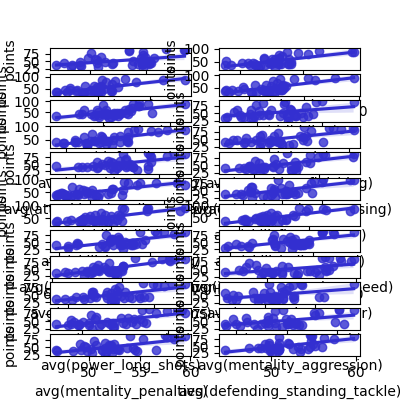

In [25]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES, TARGET_VARIABLE, figsize=(4,4), color=COLOR_RAW
)

#### Feature distribution

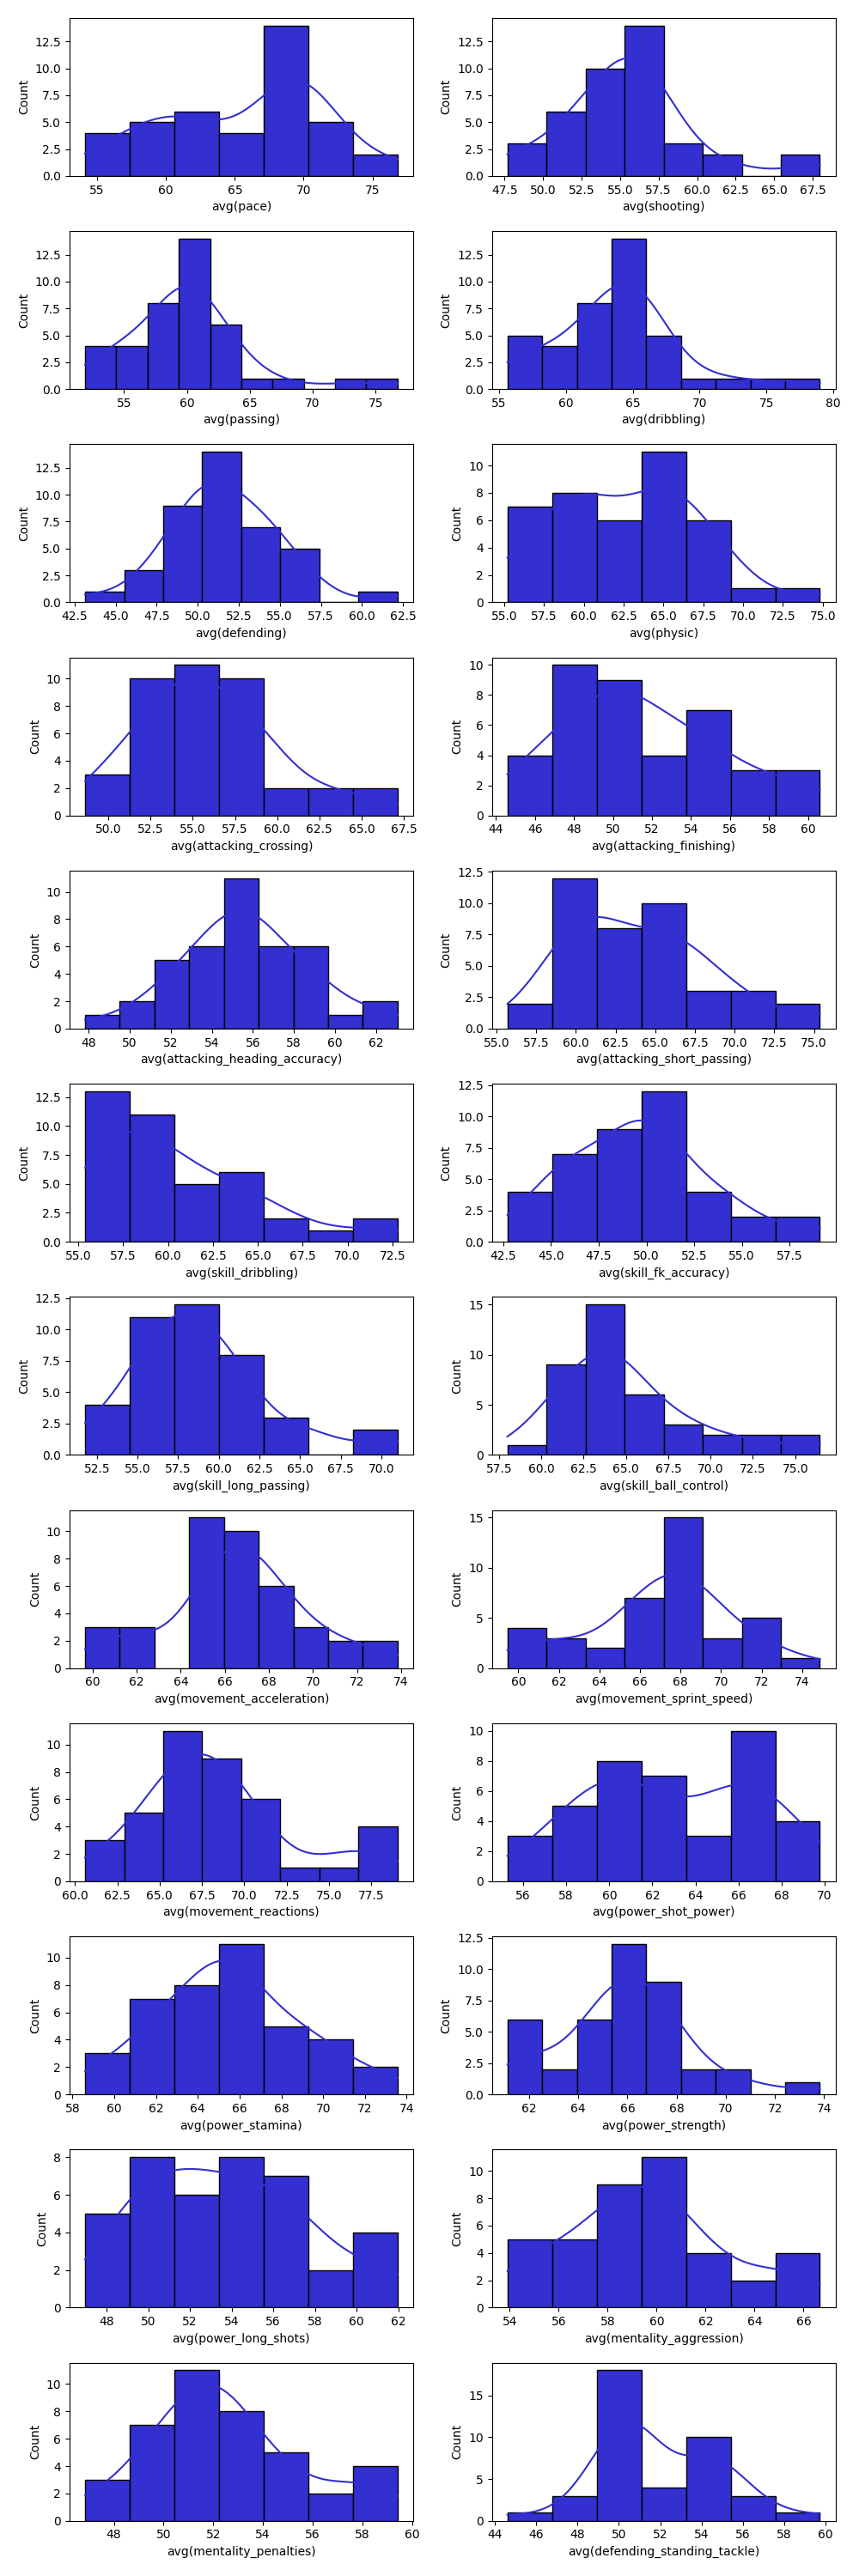

In [28]:
plot_feature_distribution(pdf, ALL_FEATURES, color = COLOR_RAW, figsize=(4,4))

#### Pearson Correlation Matrix

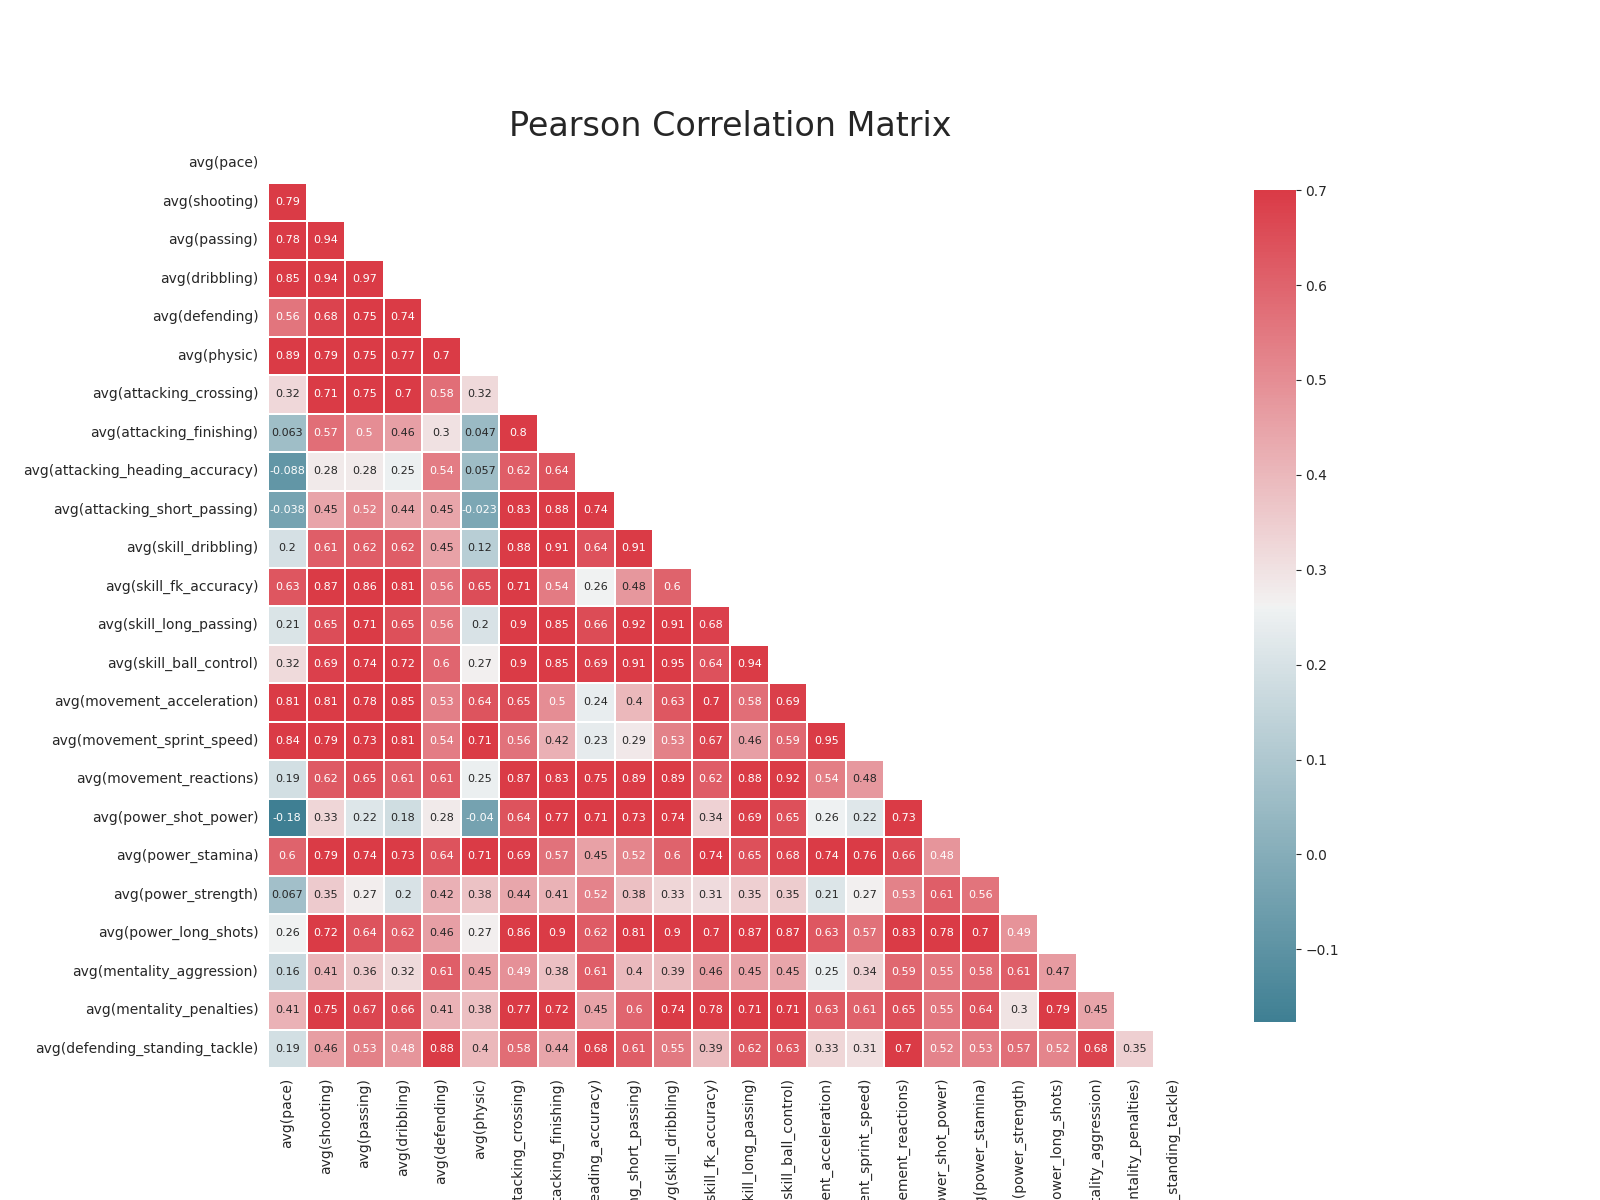

In [27]:
plot_correlation_matrix(pdf, ALL_FEATURES)

### Standardization

Since we have some features with skewed distributions, we'll try to standardize, to see whether it helps with feature skewness or not

In [29]:
standardized_df = df

In [30]:
scaler = StandardScaler(
    inputCol="all_vec", 
    outputCol="all_vec_std", 
    withStd=True, 
    withMean=True
)

In [31]:
standardized_df = scaler.fit(standardized_df).transform(standardized_df)

In [32]:
COLOR_STD = "#9254C8"

ALL_FEATURES_STD = [
    player_feature + "_std" for player_feature in ALL_FEATURES
]

In [37]:
pdf = standardized_df.toPandas()

In [38]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + ALL_FEATURES_STD
)

pdf[ALL_FEATURES_STD] = pdf[
    "all_vec_std"
].transform(
    {
        ALL_FEATURES_STD[i]: itemgetter(i) for i, p in enumerate(ALL_FEATURES_STD)
    }

    
)

#### Feature-target correlation

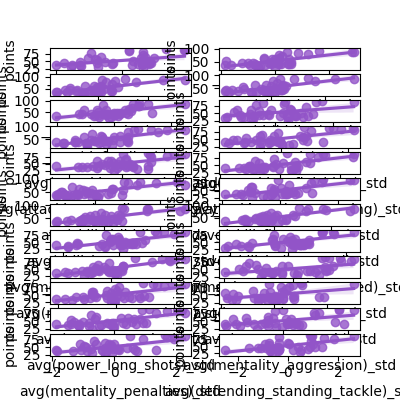

In [39]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES_STD, TARGET_VARIABLE, figsize=(4,4), color=COLOR_STD
)

#### Feature distribution

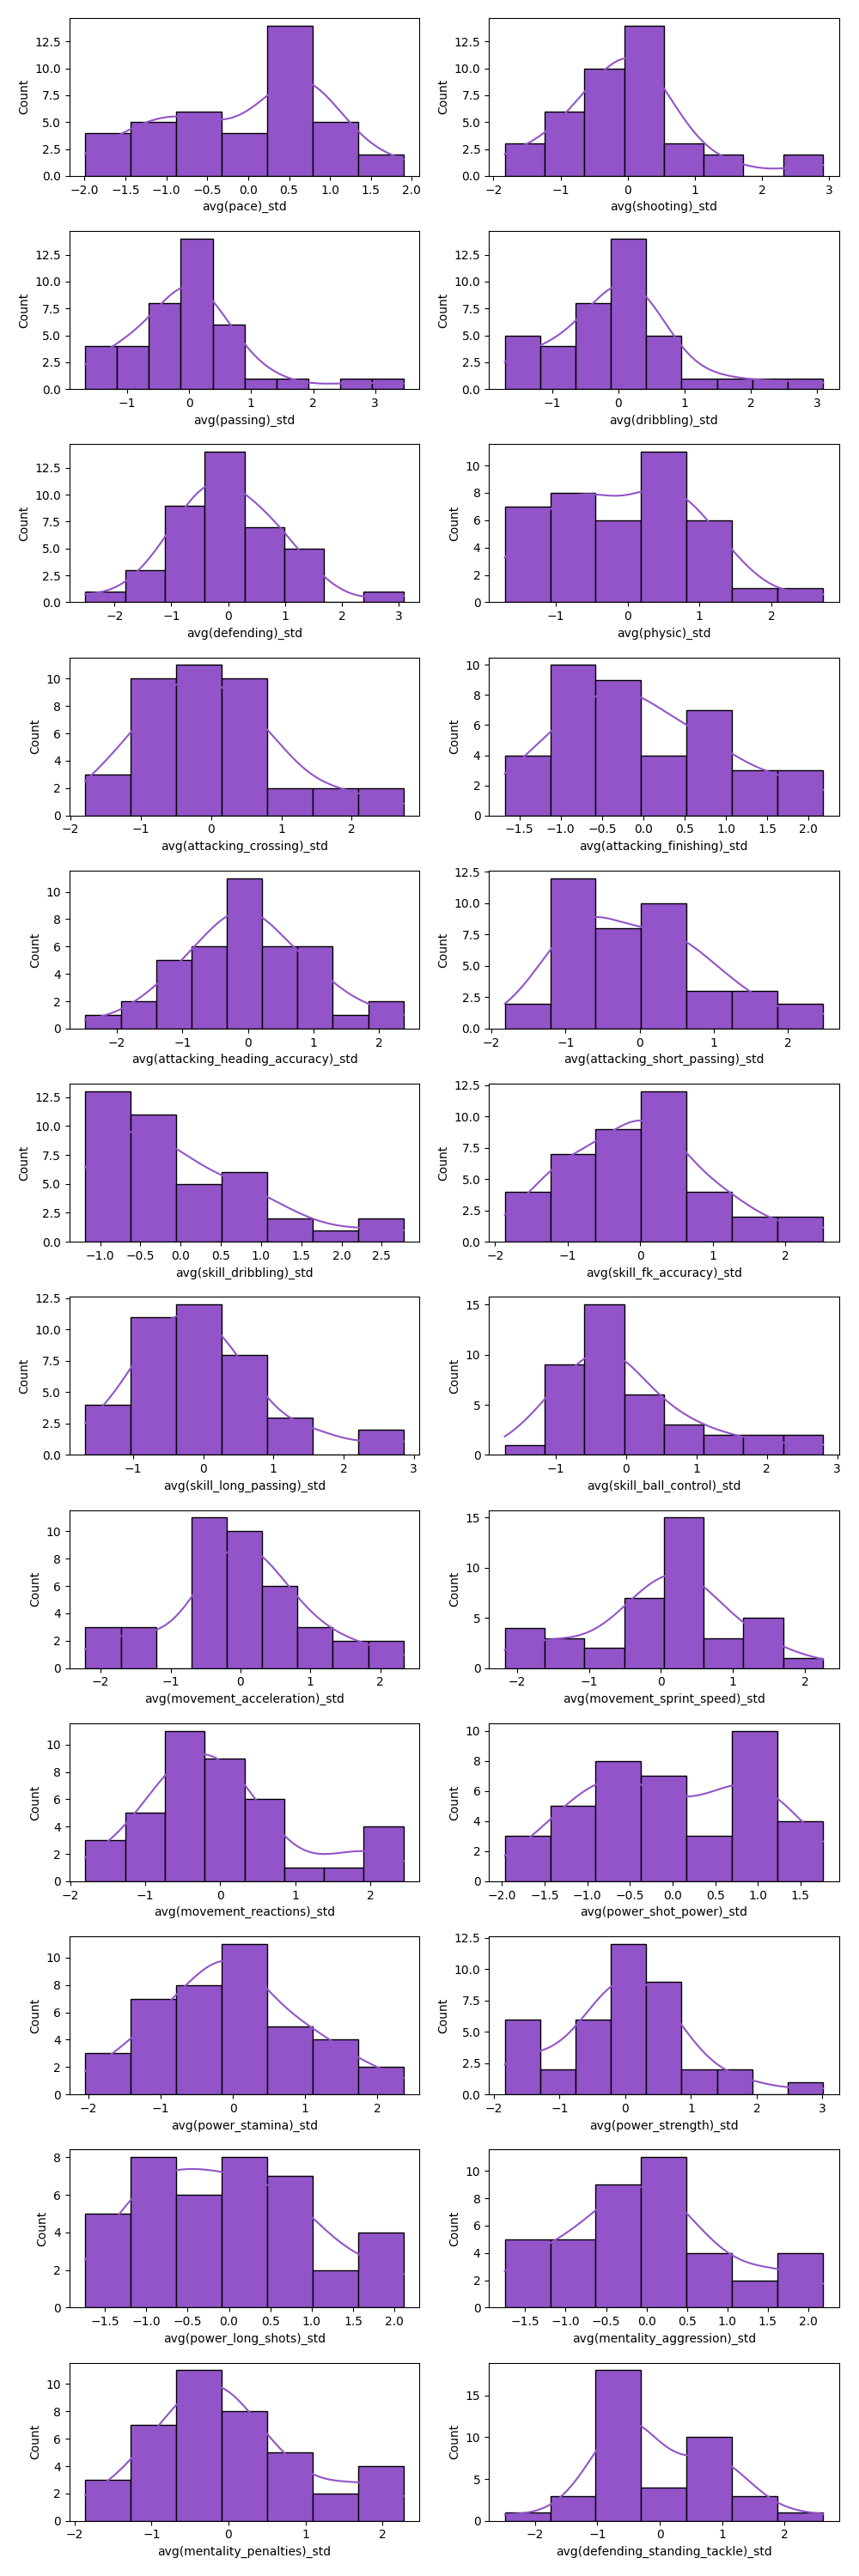

In [40]:
plot_feature_distribution(
    pdf, ALL_FEATURES_STD, color = COLOR_STD, figsize=(10,10)
)

*[state why pearson correlation matrix does NOT make sense to be plotted again]*

### Log transformation

In [41]:
log_df = df

In [42]:
ALL_FEATURES_LOG = [
    player_feature + "_log" for player_feature in ALL_FEATURES
]

COLOR_LOG = "#E15FED"

In [43]:
to_log_UDF = udf(
    lambda value: float(np.log2(value)), DoubleType()
)

In [44]:
for f, fl in zip(ALL_FEATURES, ALL_FEATURES_LOG):
    log_df = log_df.withColumn(fl, to_log_UDF(col(f)))

In [46]:
pdf = log_df.toPandas()

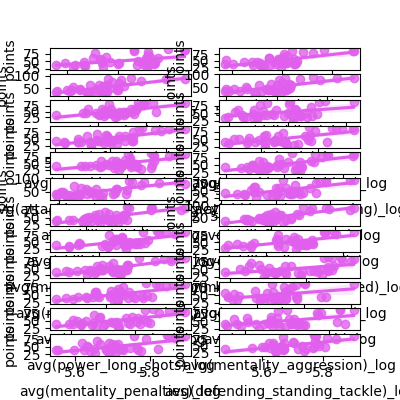

In [48]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES_LOG, TARGET_VARIABLE, figsize=(4,4), color=COLOR_LOG
)

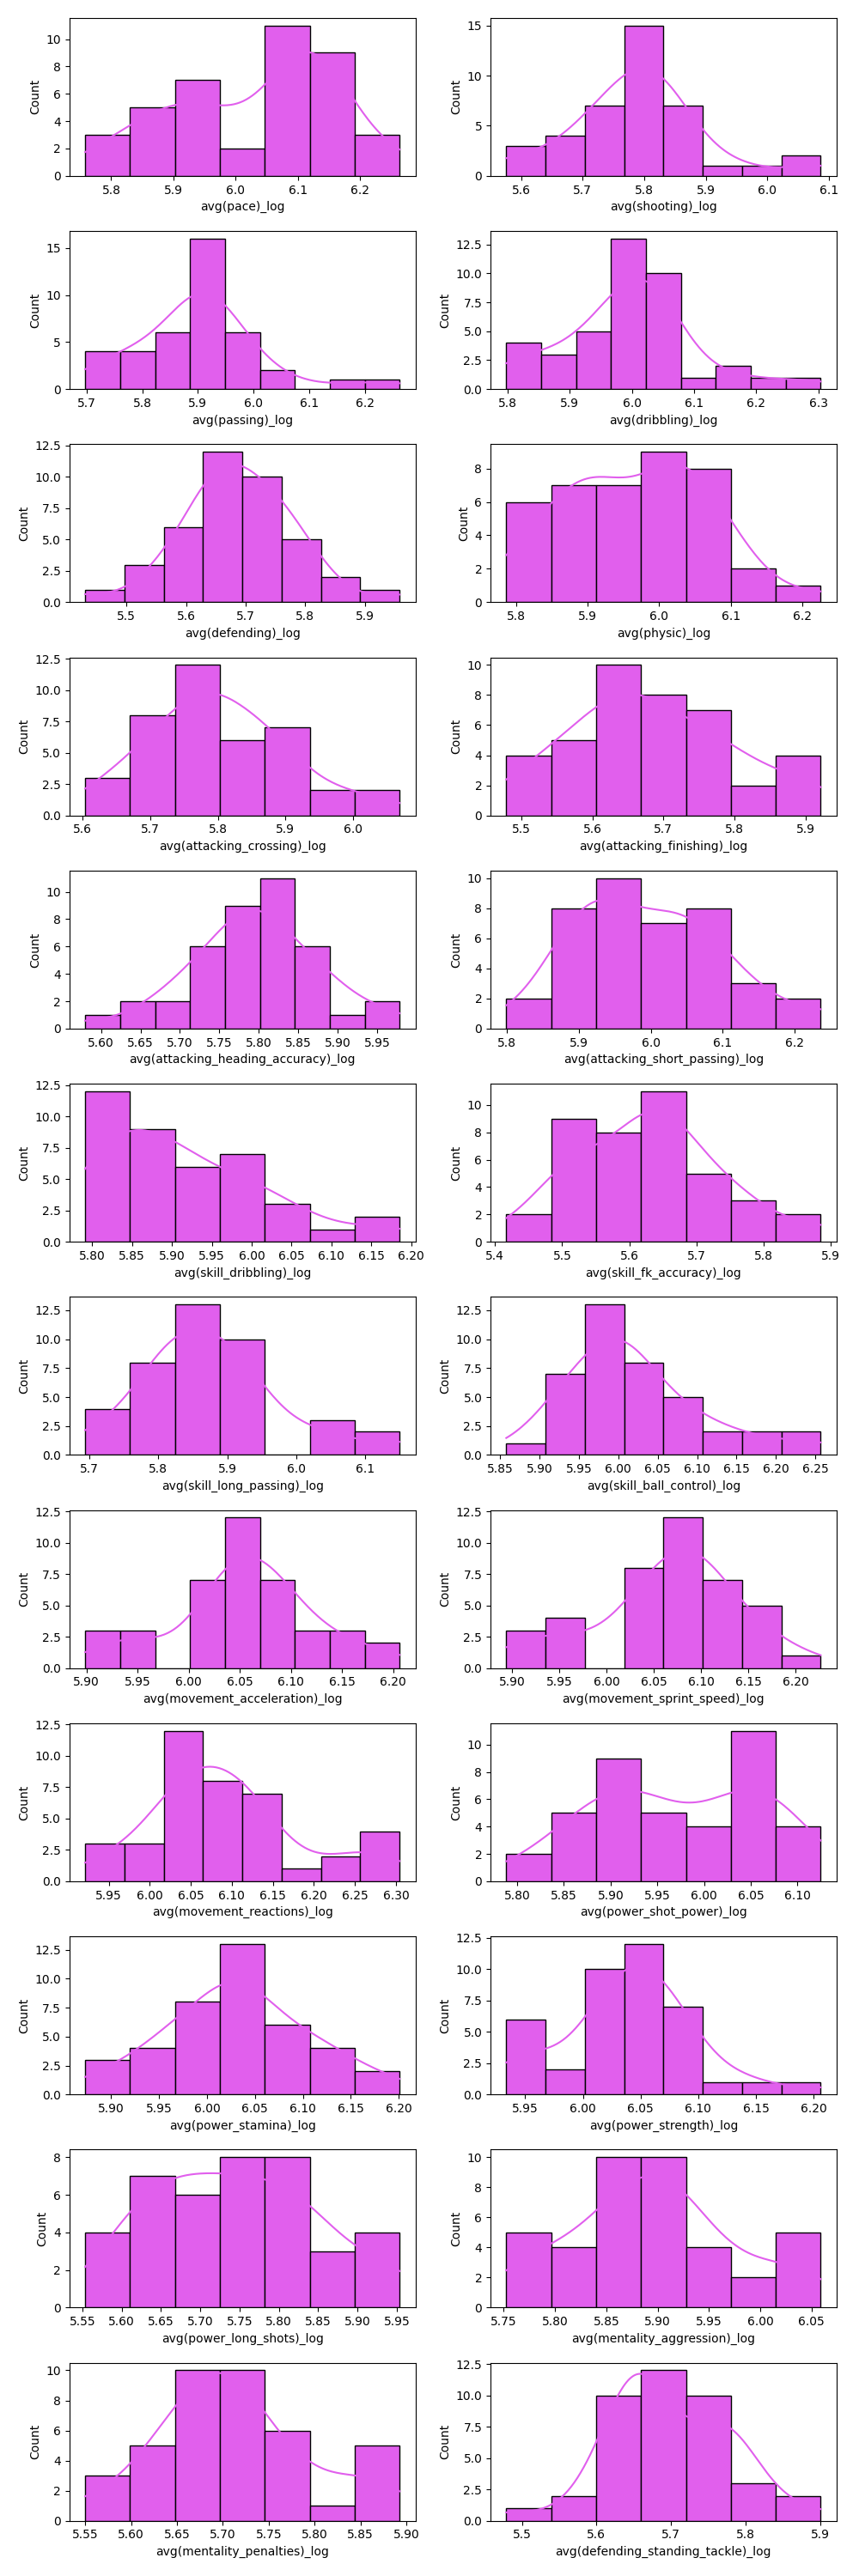

In [47]:
plot_feature_distribution(pdf, ALL_FEATURES_LOG, color = COLOR_LOG, figsize=(10,10))

### Min-max transformation

In [49]:
min_max_df = df

In [50]:
ALL_FEATURES_MIN_MAX = [
    player_feature + "_min_max" for player_feature in ALL_FEATURES
]

COLOR_MIN_MAX = "#6EDCD9"

In [51]:
scaler = MinMaxScaler(
    inputCol="all_vec", 
    outputCol="all_vec_min_max"
)

In [52]:
min_max_df = scaler.fit(min_max_df).transform(min_max_df)

In [56]:
pdf = min_max_df.toPandas()

In [57]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + ALL_FEATURES_MIN_MAX
)

pdf[ALL_FEATURES_MIN_MAX] = pdf[
    "all_vec_min_max"
].transform(
    {
        ALL_FEATURES_MIN_MAX[i]: itemgetter(i) for i, p in enumerate(ALL_FEATURES_MIN_MAX)
    }
)

#### Feature-target relationship

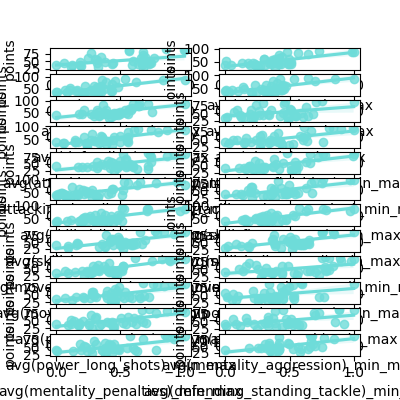

In [58]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES_MIN_MAX, TARGET_VARIABLE, figsize=(4,4), color=COLOR_MIN_MAX
)

#### Feature distribution

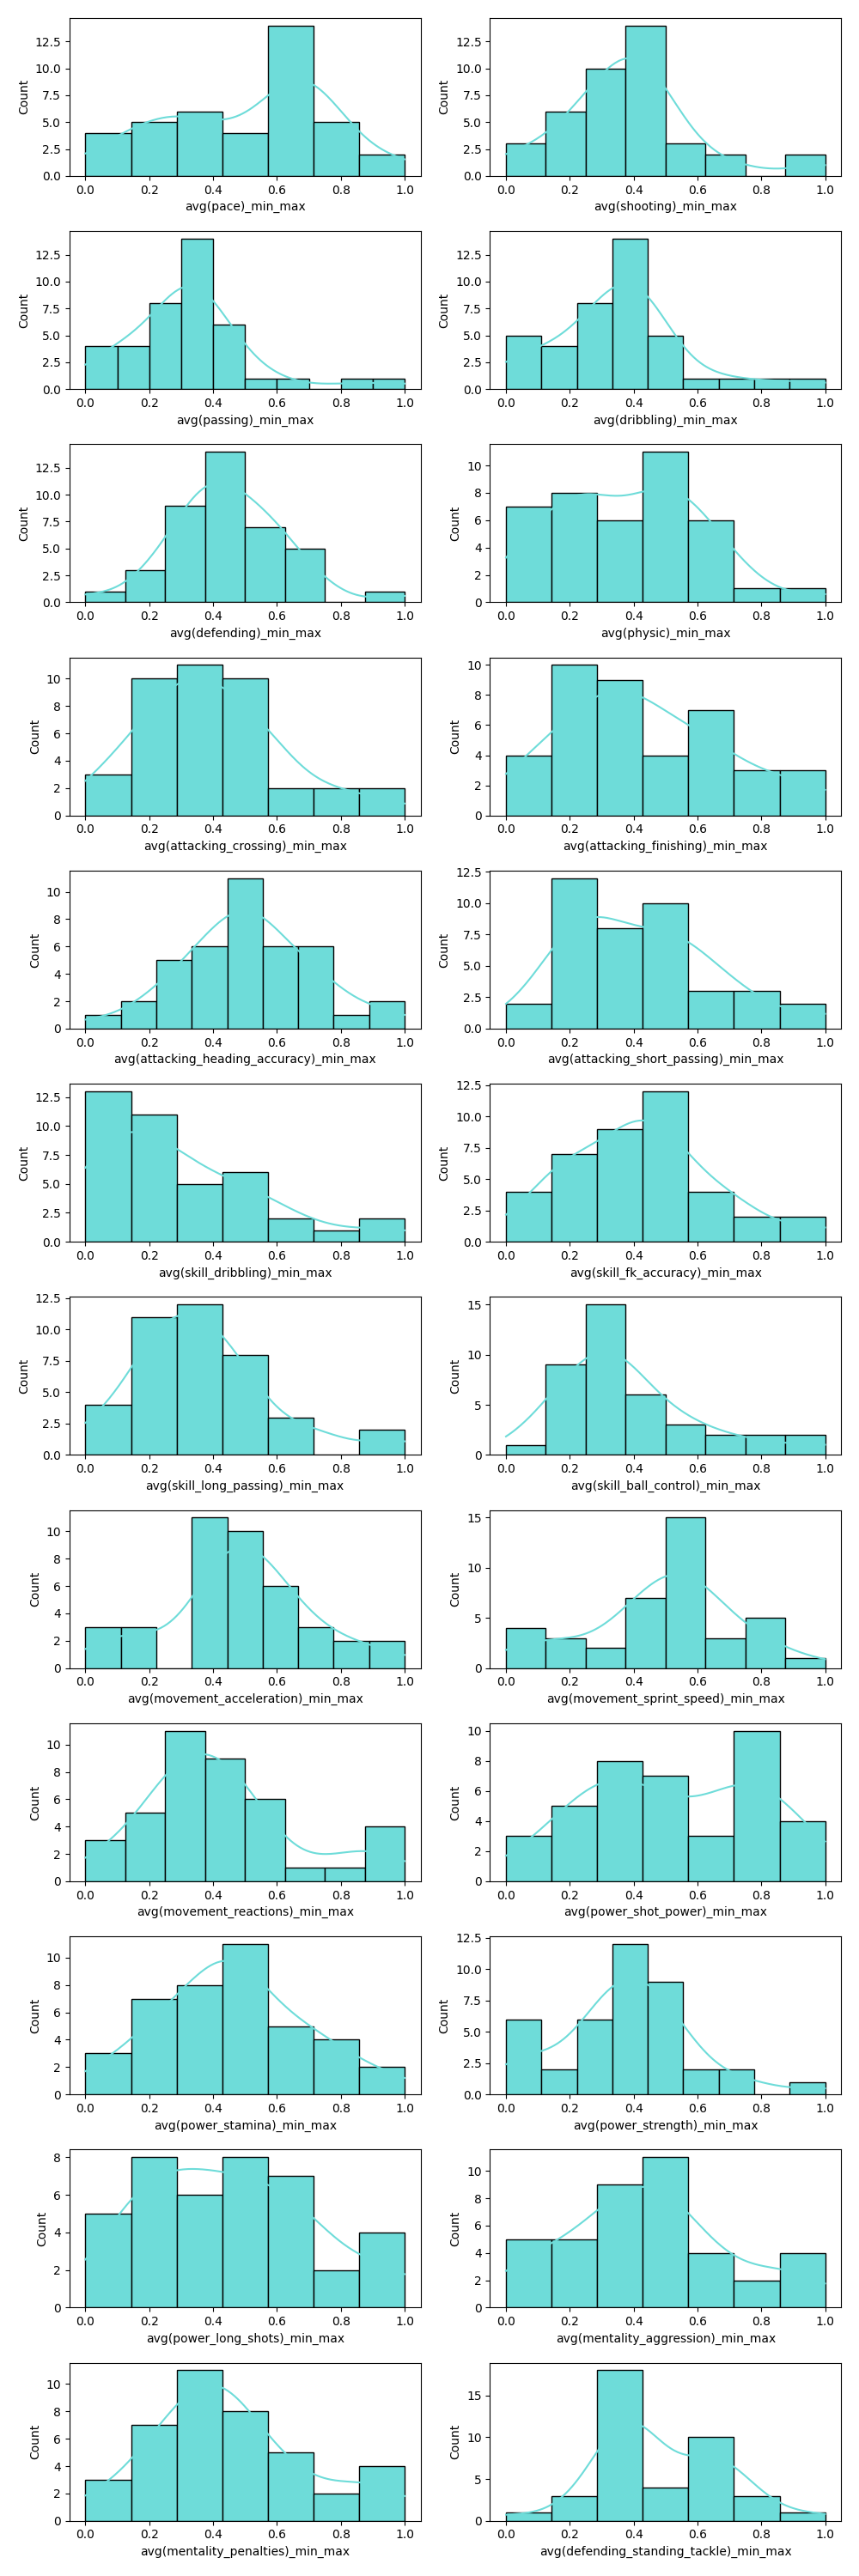

In [59]:
plot_feature_distribution(pdf, ALL_FEATURES_MIN_MAX, color = COLOR_MIN_MAX, figsize=(10,10))

#### PCA

In [ ]:
pca_df = min_max_df

PCA_NUM_COMPONENTS = 5
PCA_NUM_COMPONENTS_TO_PLOT = 2

pca = PCA(
    k=PCA_NUM_COMPONENTS, 
    inputCol="all_vec_min_max", 
    outputCol="pcs_min_max"
)

pca_model = pca.fit(pca_df)
pca_df = pca_model.transform(pca_df)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
_ = sns.barplot(
    x=[i for i in range(PCA_NUM_COMPONENTS_TO_PLOT)],
    y=pca_model.explainedVariance.values[0:PCA_NUM_COMPONENTS_TO_PLOT],
    ax=ax,
)

_ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
_ = ax.set_ylabel("Proportion of Variance", fontsize=16)
_ = ax.set_xticklabels(
    [f"Principal Component {i}" for i in range(PCA_NUM_COMPONENTS_TO_PLOT)], 
    rotation=0
)
_ = ax.set_title("Explained variance of each Principal Component")

In [ ]:
pca_pdf = pca_df.toPandas()

In [ ]:
scatter_plot(
    pca_pdf, 
    pca_pdf.pcs_min_max.map(lambda x: x[0]),
    pca_pdf.pcs_min_max.map(lambda x: x[1]),
    pca_pdf.points,
    "Principal Component 0",
    "Principal Component 1"
)

In [ ]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.pcs_min_max.map(lambda x: x[0]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 0",
    "Points"
)

In [ ]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.pcs_min_max.map(lambda x: x[1]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 1",
    "Points"
)

*[bridge between this and Feature selection]*

## Feature selection

### Univariate Feature Selection

Log scaling reduces skewedness of "avg(mentality_penalties)" feature BUT it increases the skewedness of all the other features.
The other scalings (z-score and min-max) do NOT appear to be different than the "raw" data distribution.

For this reason and due to the limited amount of resources available on Google Colab, we decided to stick with the min-max scaled data.
In fact, the min-max scaling places "for free" all the features in the same scale, which is a very important consideration for SVM, which will be used in the upcoming sections

In [60]:
feature_selection_df = min_max_df

In [61]:
selector = UnivariateFeatureSelector(
    featuresCol="all_vec",
    labelCol=TARGET_VARIABLE, 
    selectionMode="percentile"
).setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(0.08)

In [62]:
NUM_FEATURES = 2

In [64]:
fit_result = dict()

# for thr in range(0.1, 1.1, 0.1):
# for thr in np.linspace(1, 1, 1):
for thr in [0.1]:

    selector.setSelectionThreshold(thr)
    selector.setOutputCol("ufs_" + str(thr).replace(".", "-")),
    fit_result[str(thr)] = selector.fit(df)
    feature_selection_df = fit_result[str(thr)].transform(
        feature_selection_df
    )


In [65]:
def scatter_plot(data, x, y, c, x_label, y_label):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    _ = plt.scatter(
        x = x,
        y = y,
        c = c,
        edgecolor="none",
        alpha=1,
        cmap="rainbow",
        axes=ax
    )

    _ = ax.set_xlabel(x_label, labelpad=20, fontsize=16)
    _ = ax.set_ylabel(y_label, fontsize=16)

    plt.colorbar()
    plt.show()

In [66]:
feature_selection_pdf = feature_selection_df.toPandas()

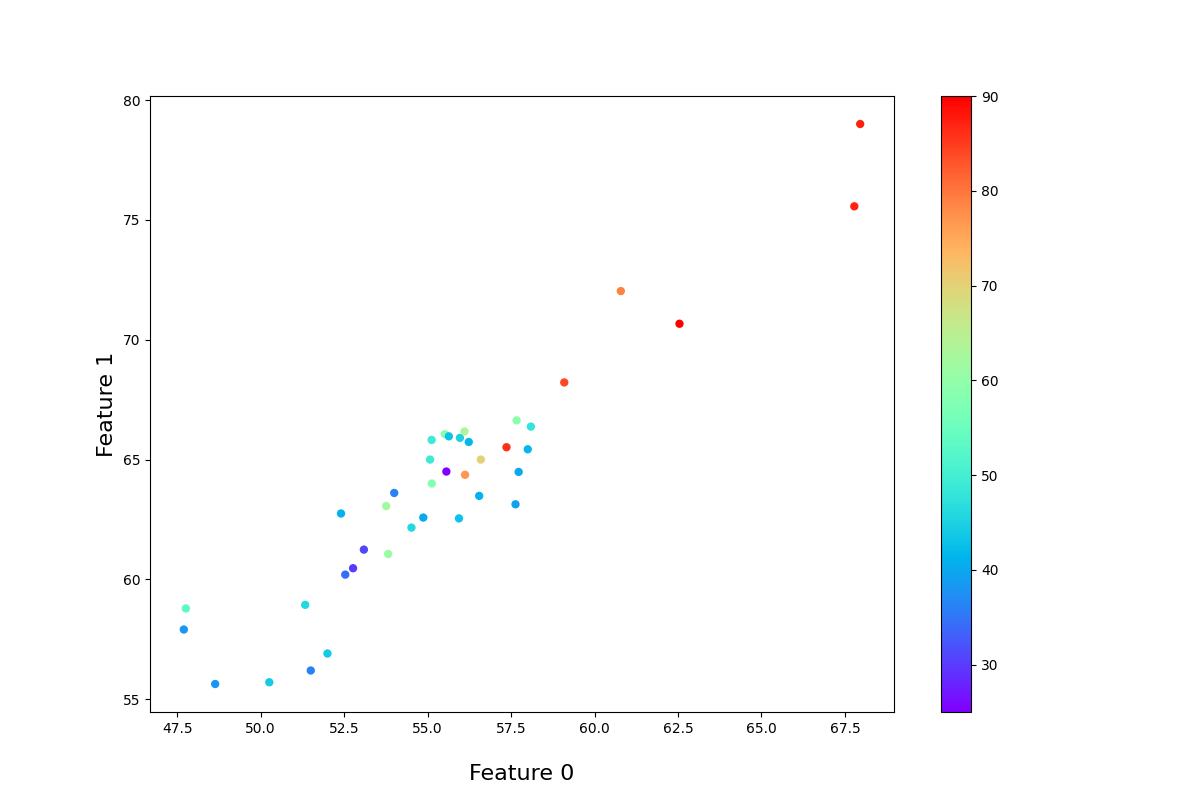

In [68]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[0]),
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[1]),
    feature_selection_pdf.points,
    "Feature 0",
    "Feature 1"
    
)

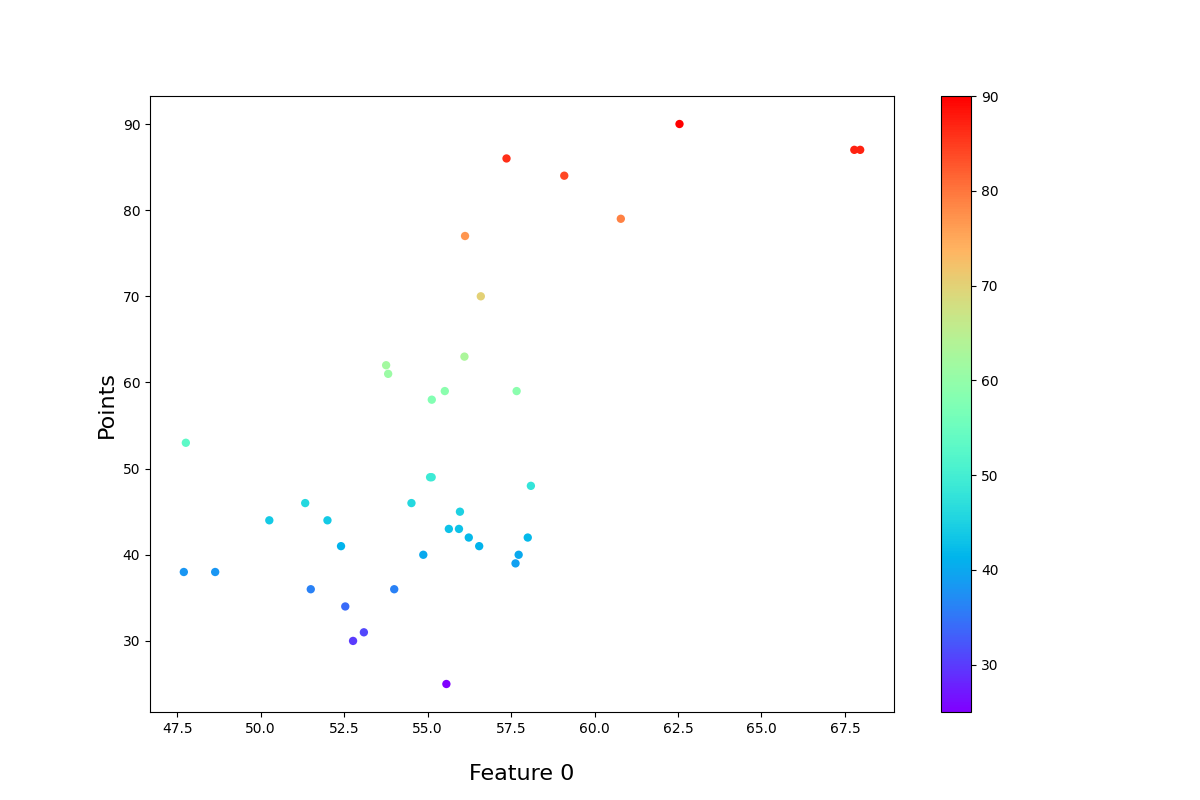

In [69]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[0]),
    feature_selection_pdf.points,
    feature_selection_pdf.points,
    "Feature 0",
    "Points"
    
)

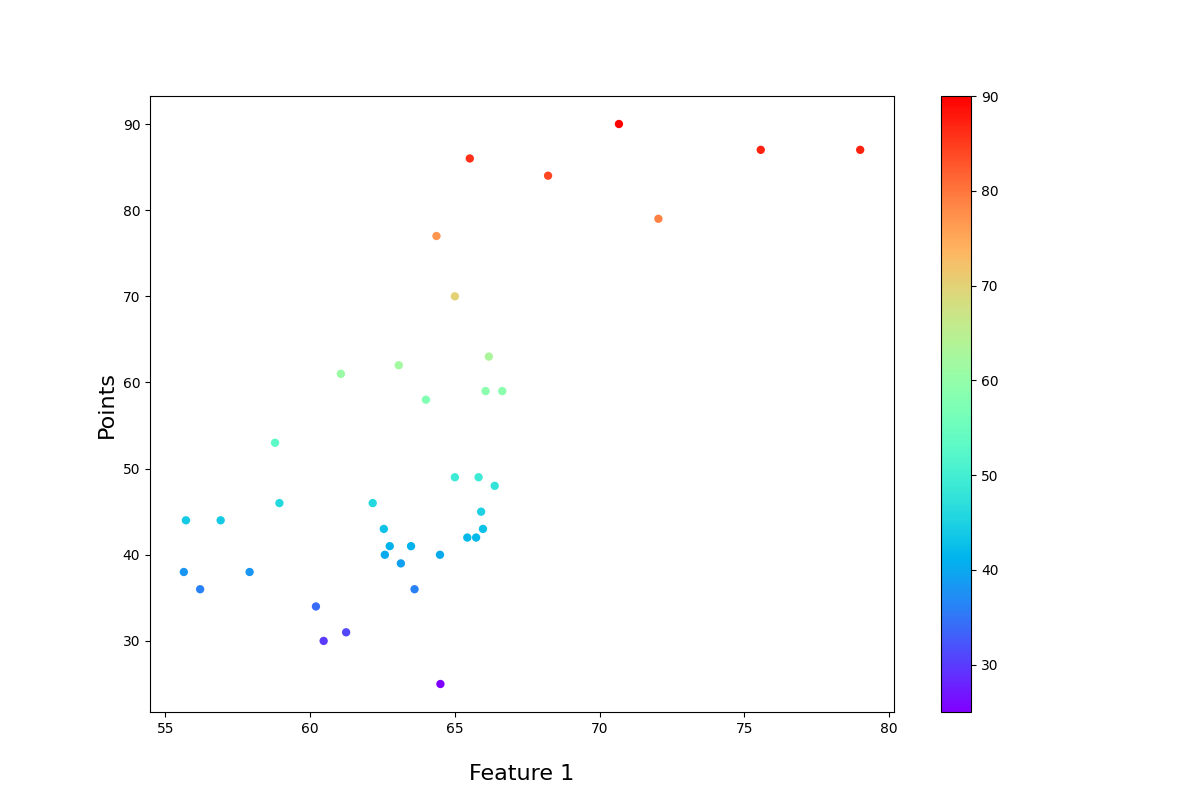

In [70]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[1]),
    feature_selection_pdf.points,
    feature_selection_pdf.points,
    "Feature 1",
    "Points"
    
)

In [91]:
pdf = feature_selection_df.toPandas()

In [108]:
selected_features = list(
    map(
        lambda i: ALL_FEATURES[i], fit_result["0.1"].selectedFeatures
    )
)

#### Feature-target relationship

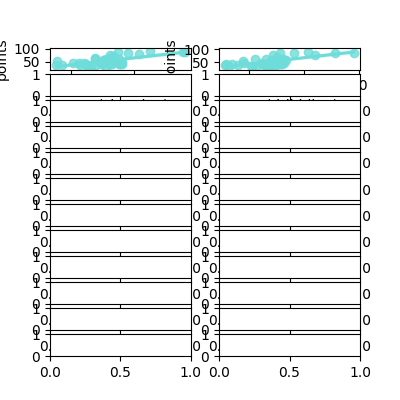

In [109]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, selected_features, TARGET_VARIABLE, figsize=(4,4), 
    color=COLOR_MIN_MAX
)

#### Feature correlation

look at it from the original pearson matrix

#### PCA

*[explain why it may make sense]*

In [ ]:
# NOTE for now, keep it off, since we only have feature selection yielding to 2 feature,
# on which it would NOT make sense to perform PCA

# pca_df = feature_selection_df

# PCA_NUM_COMPONENTS = 5
# PCA_NUM_COMPONENTS_TO_PLOT = 2

# pca = PCA(
#     k=PCA_NUM_COMPONENTS, 
#     inputCol="ufs_0-1", 
#     outputCol="pcs_min_max"
# )

# pca_model = pca.fit(pca_df)
# pca_df = pca_model.transform(pca_df)

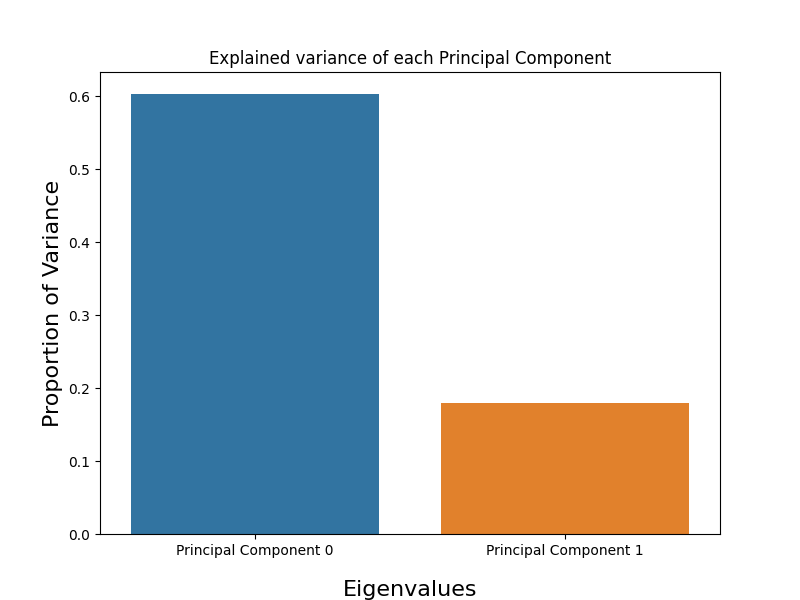

In [78]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
_ = sns.barplot(
    x=[i for i in range(PCA_NUM_COMPONENTS_TO_PLOT)],
    y=pca_model.explainedVariance.values[0:PCA_NUM_COMPONENTS_TO_PLOT],
    ax=ax,
)

_ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
_ = ax.set_ylabel("Proportion of Variance", fontsize=16)
_ = ax.set_xticklabels(
    [f"Principal Component {i}" for i in range(PCA_NUM_COMPONENTS_TO_PLOT)], 
    rotation=0
)
_ = ax.set_title("Explained variance of each Principal Component")

In [79]:
pca_pdf = pca_df.toPandas()

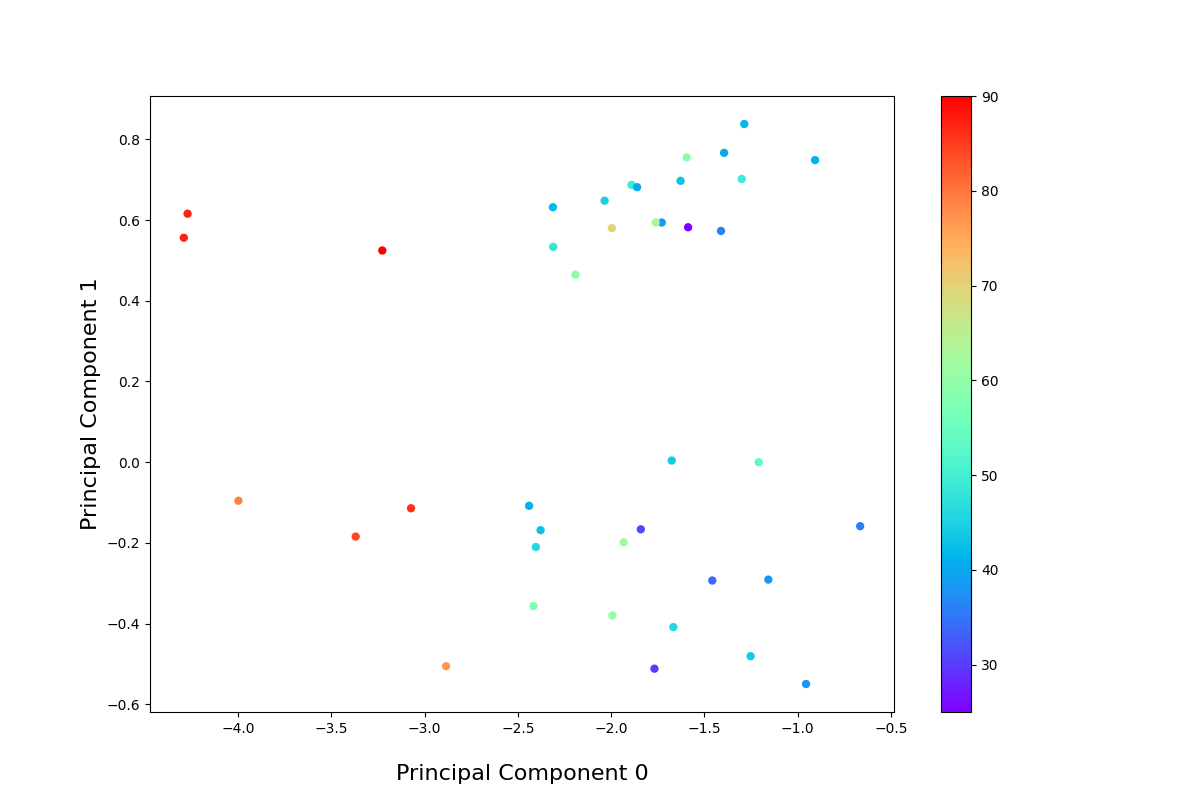

In [80]:
scatter_plot(
    pca_pdf, 
    pca_pdf.pcs_min_max.map(lambda x: x[0]),
    pca_pdf.pcs_min_max.map(lambda x: x[1]),
    pca_pdf.points,
    "Principal Component 0",
    "Principal Component 1"
)

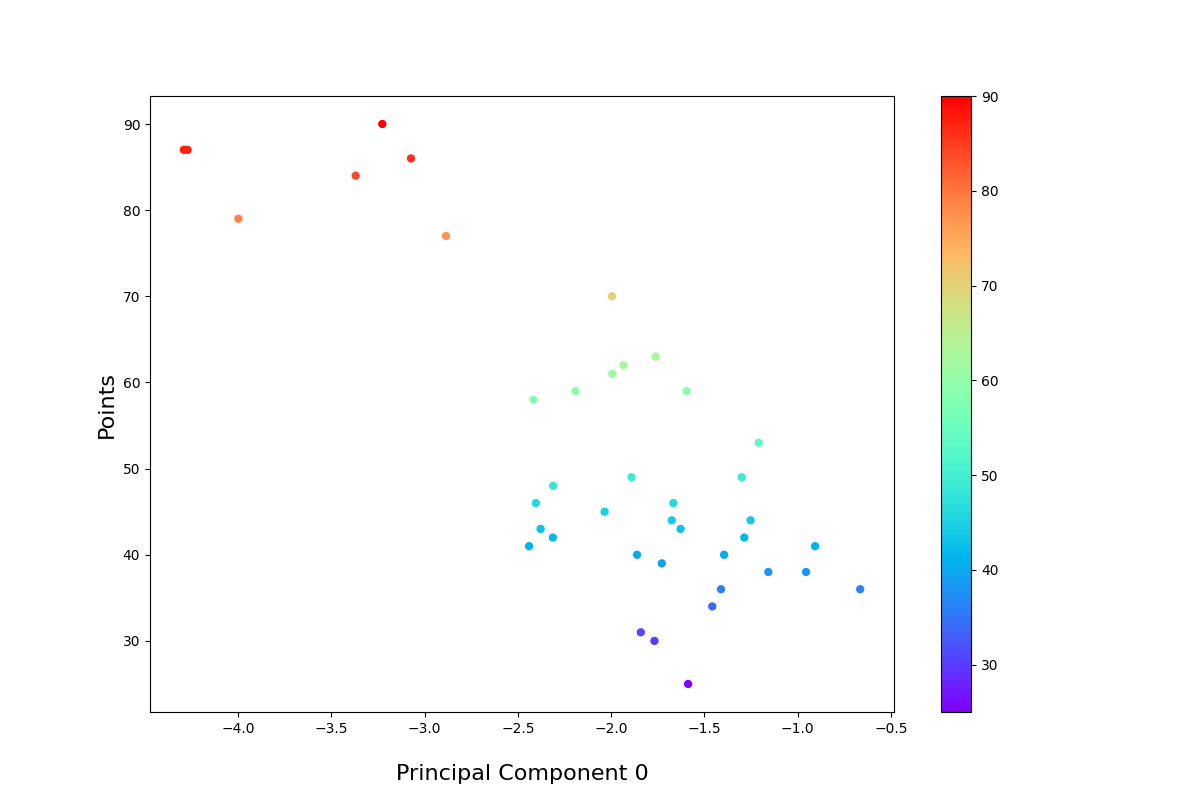

In [81]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.pcs_min_max.map(lambda x: x[0]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 0",
    "Points"
)

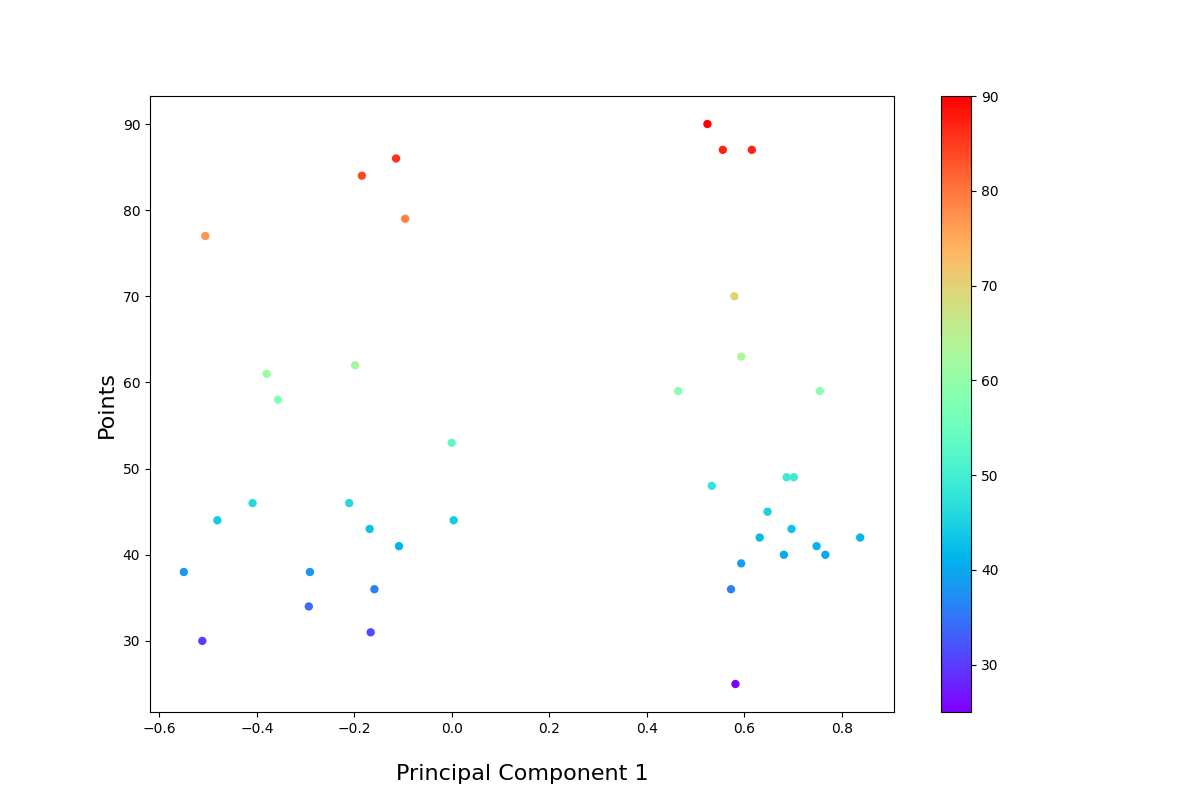

In [82]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.pcs_min_max.map(lambda x: x[1]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 1",
    "Points"
)

state that these data distribs are trash.

So, for this reason, talk about overall and value.

# Overall/value attempt

In [86]:
OVERALL = ["avg(overall)"]

VALUE = ["avg(value)"]

In [87]:
assembler = VectorAssembler(
    inputCols=OVERALL, outputCol="overall_vec"
)

min_max_df = assembler.transform(min_max_df)

assembler = VectorAssembler(
    inputCols=VALUE, outputCol="value_vec"
)

min_max_df = assembler.transform(min_max_df)

In [88]:
min_max_df.printSchema()

root
 |-- season: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- avg(attacking_short_passing): double (nullable = true)
 |-- avg(shooting): double (nullable = true)
 |-- avg(power_stamina): double (nullable = true)
 |-- avg(skill_long_passing): double (nullable = true)
 |-- avg(power_strength): double (nullable = true)
 |-- avg(defending_standing_tackle): double (nullable = true)
 |-- avg(skill_fk_accuracy): double (nullable = true)
 |-- avg(skill_dribbling): double (nullable = true)
 |-- avg(dribbling): double (nullable = true)
 |-- avg(pace): double (nullable = true)
 |-- avg(mentality_aggression): double (nullable = true)
 |-- avg(movement_reactions): double (nullable = true)
 |-- avg(movement_sprint_speed): double (nullable = true)
 |-- avg(passing): double (nullable = true)
 |-- avg(movement_acceleration): double (nullable = true)
 |-- avg(attacking_heading_accuracy): double (nullable = true)
 |-- avg(attacking_finishing): double (nullable = true)
 |-- avg(

In [ ]:
OVERALL_MIN_MAX = ["avg(overall)_min_max"]
VALUE_MIN_MAX = ["avg(value)_min_max"]

COLOR_OVERALL_RAW = "green"

Look, they are basically the same. In fact, if we check their correlation, we get... [high correlation on pearson]

# Learning

*[
    state that via hyperparam grid we'll set the feature column, meaning that we'll try to train the models on all of the attemps

[state expected results, according to correlations and similar stuff]

]

In [ ]:
feature_selection_learning_df = feature_selection_df

In [ ]:
feature_selection_train_df, feature_selection_test_df = feature_selection_learning_df.randomSplit(
    # [0.9, 0.1]
    [0.7, 0.3]
)

In [ ]:
NUM_FOLDS_CV = 5

In [ ]:
def find_best_regressor(
    train_df,
    test_df,
    regressor,
    regressor_evaluation_metrics,
    cv_evaluation_metrics,
    hyperparams_grid
):

    cv_evaluators = {
        metric: RegressionEvaluator(
            labelCol="points",
            metricName=metric,
        )
        for metric in cv_evaluation_metrics
    }

    regressor_evaluators = {
        metric: RegressionEvaluator(
            labelCol="points",
            metricName=metric,
        )
        for metric in regressor_evaluation_metrics
    }

    cross_validations = {
        metric: CrossValidator(
            estimator=regressor,
            estimatorParamMaps=hyperparams_grid,
            evaluator=cv_evaluators[metric],
            numFolds=NUM_FOLDS_CV,
            collectSubModels=True
        )
        for metric in cv_evaluation_metrics
    }

    cross_validated = dict()

    for metric in cv_evaluation_metrics:

        cross_validated[metric] = cross_validations[
            metric
        ].fit(train_df)

    if (isinstance(regressor, LinearRegression)):
        
        for metric in cv_evaluation_metrics:

            training_result = cross_validated[
                metric
            ].bestModel.summary

            print(
                "***** Evaluating Training Set, (Linear Regression, best model according to metric {}) *****".format(
                    metric
                )
            )
            print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
            print("R2: {:.3f}".format(training_result.r2))
            print("Adjusted R2: {:.3f}".format(training_result.r2adj))
            print()

        predictions = {
            metric: cross_validated[
                metric
            ].bestModel.transform(test_df)
            for metric in cv_evaluation_metrics
        }

        for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        "Test", m
                    )
                )

                for e, evaluator in regressor_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")

    else:

        for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
            predictions = {
                metric: cross_validated[
                    metric
                ].bestModel.transform(stage_df)
                for metric in cv_evaluation_metrics
            }

            for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        stage_name, m
                    )
                )

                for e, evaluator in regressor_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")



In [ ]:
def find_best_classifier(
    train_df,
    test_df,
    classifier,
    classifier_evaluation_metrics,
    cv_evaluation_metrics,
    hyperparams_grid
):

    cv_evaluators = {
        metric: MulticlassClassificationEvaluator(
            labelCol="macro_place",
            metricName=metric,
        )
        for metric in cv_evaluation_metrics
    }

    classifier_evaluators = {
        metric: MulticlassClassificationEvaluator(
            labelCol="macro_place",
            metricName=metric,
        )
        for metric in classifier_evaluation_metrics
    }

    cross_validations = {
        metric: CrossValidator(
            estimator=classifier,
            estimatorParamMaps=hyperparams_grid,
            evaluator=cv_evaluators[metric],
            numFolds=NUM_FOLDS_CV,
            collectSubModels=True
        )
        for metric in cv_evaluation_metrics
    }

    cross_validated = dict()

    for metric in cv_evaluation_metrics:

        cross_validated[metric] = cross_validations[
            metric
        ].fit(train_df)

    if (isinstance(classifier, LinearRegression)):
        
        for metric in cv_evaluation_metrics:

            training_result = cross_validated[
                metric
            ].bestModel.summary

            print(
                "***** Evaluating Training Set, (Linear Regression, best model according to metric {}) *****".format(
                    metric
                )
            )
            print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
            print("R2: {:.3f}".format(training_result.r2))
            print("Adjusted R2: {:.3f}".format(training_result.r2adj))
            print()

        predictions = {
            metric: cross_validated[
                metric
            ].bestModel.transform(test_df)
            for metric in cv_evaluation_metrics
        }

        for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        "Test", m
                    )
                )

                for e, evaluator in classifier_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")

    else:

        for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
            predictions = {
                metric: cross_validated[
                    metric
                ].bestModel.transform(stage_df)
                for metric in cv_evaluation_metrics
            }

            for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        stage_name, m
                    )
                )

                for e, evaluator in classifier_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")



### Regression

#### Linear Regression

In [ ]:
lr_train_df, lr_test_df = feature_selection_train_df, feature_selection_test_df

In [ ]:
lr = LinearRegression(
    # featuresCol="feature_vec_ufs_0.1", 
    labelCol="points"
)

lr_evaluation_metrics = ["r2", "mse"]
lr_evaluation_metrics_cv = ["r2"]

lr_param_grid = (
    ParamGridBuilder()
    .addGrid(lr.featuresCol, [
        "feature_vec_ufs_0-1", 
        # "feature_vec_min_max",
        #TODO use PCA column
        # "feature_vec_std"
    ])
    #TODO add intermediate values: prof uses [0.0, 0.5, 1]
    .addGrid(lr.elasticNetParam, [0.0, 1])
    #TODO add intermediate values: prof uses [0.0, 0.05, 0.1]
    .addGrid(lr.regParam, [0.0, 0.1])
    .addGrid(lr.fitIntercept, [True, False])
    .build()
)

find_best_regressor(
    train_df=lr_train_df, 
    test_df=lr_test_df, 
    regressor=lr,
    regressor_evaluation_metrics=lr_evaluation_metrics,
    cv_evaluation_metrics=lr_evaluation_metrics_cv,
    hyperparams_grid=lr_param_grid
)

#### Decision Tree

In [ ]:
dt_train_df, dt_test_df = feature_selection_train_df, feature_selection_test_df

In [ ]:
dt = DecisionTreeRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

dt_evaluation_metrics = ["r2", "mse"]
dt_evaluation_metrics_cv = ["r2"]

dt_param_grid = (
    ParamGridBuilder()
    .addGrid(dt.featuresCol, [
        "feature_vec_ufs_0-1", 
        "overall_vec"
        # "feature_vec_min_max",
        #TODO use PCA column
        # "feature_vec_std"
    ])
    # .addGrid(dt.standardization, [True, False])
    .build()
)

find_best_regressor(
    train_df=dt_train_df, 
    test_df=dt_test_df, 
    regressor=dt,
    regressor_evaluation_metrics=dt_evaluation_metrics,
    cv_evaluation_metrics=dt_evaluation_metrics_cv,
    hyperparams_grid=dt_param_grid
)

#### Random Forest

In [ ]:
rf_train_df, rf_test_df = feature_selection_train_df, feature_selection_test_df

In [ ]:
rf = RandomForestRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

rf_evaluation_metrics = ["r2", "mse"]
rf_evaluation_metrics_cv = ["r2"]

rf_param_grid = (
    ParamGridBuilder()
    .addGrid(rf.featuresCol, [
        "feature_vec_ufs_0-1", 
        # "feature_vec_min_max",
        #TODO use PCA column
        # "feature_vec_std"
        # "overall_vec"
    ])
    # .addGrid(rf.standardization, [True, False])
    .build()
)


In [ ]:
find_best_regressor(
    train_df=rf_train_df, 
    test_df=rf_test_df, 
    regressor=rf,
    regressor_evaluation_metrics=rf_evaluation_metrics,
    cv_evaluation_metrics=rf_evaluation_metrics_cv,
    hyperparams_grid=rf_param_grid
)

#### Gradient Boosted Tree

In [ ]:
gbt_train_df, gbt_test_df = feature_selection_train_df, feature_selection_test_df

In [ ]:
gbt = GBTRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

gbt_evaluation_metrics = ["r2", "mse"]
gbt_evaluation_metrics_cv = ["r2"]

gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(gbt.featuresCol, [
        "feature_vec_ufs_0-1", 
        # "feature_vec_min_max",
        #TODO use PCA column
        # "feature_vec_std"
        # "overall_vec"
    ])
    # .addGrid(gbt.standardization, [True, False])
    .build()
)


In [ ]:
find_best_regressor(
    train_df=gbt_train_df, 
    test_df=gbt_test_df, 
    regressor=gbt,
    regressor_evaluation_metrics=gbt_evaluation_metrics,
    cv_evaluation_metrics=gbt_evaluation_metrics_cv,
    hyperparams_grid=gbt_param_grid
)

### Classification

In [ ]:
# TODO evaluate more advanced, dynamic macro placements
def get_macro_place(place, league):

    if league == "German Bundesliga":
        if 1 <= place <= 4:
            return 0.0
        if 5 <= place <= 7:
            return 1.0
        if 8 <= place <= 10:
            return 2.0
        if 11 <= place <= 15:
            return 3.0
        if 16 <= place <= 18:
            return 4.0

    elif league == "Holland Eredivise":
        if place == 1:
            return 0.0
        if 2 <= place <= 3:
            return 1.0
        if 4 <= place <= 9:
            return 2.0
        if 10 <= place <= 15:
            return 3.0
        if 16 <= place <= 18:
            return 4.0


    elif league == "French League 1":
        if 1 <= place <= 2:
            return 0.0
        if 3 <= place <= 5:
            return 1.0
        if 6 <= place <= 11:
            return 2.0
        if 12 <= place <= 17:
            return 3.0
        if 18 <= place <= 20:
            return  4.0
    
    else: #It, Sp, En
        if 1 <= place <= 4:
            return 0.0
        if 5 <= place <= 7:
            return 1.0
        if 8 <= place <= 12:
            return 2.0
        if 13 <= place <= 17:
            return 3.0
        if 18 <= place <= 20:
            return 4.0

    return None

get_macro_place_UDF = udf(
    lambda place, league: get_macro_place(float(place), league),
    DoubleType(),
)

NUM_MACRO_PLACES = 5

In [ ]:
classification_df = feature_selection_learning_df

In [ ]:
classification_df = classification_df.withColumn(
    "macro_place", get_macro_place_UDF(col("place"), col("League"))
)

In [ ]:
classification_train_df, classification_test_df = classification_df.randomSplit([0.9, 0.1])

#### Data visualizations

In [ ]:
plot_feature_distribution(
    classification_df.toPandas(), 
    ["macro_place"], 
    color = "teal", 
    figsize=(10,10)
)

#### SVM

In [ ]:
svm_train_df, svm_test_df = classification_train_df, classification_test_df

In [ ]:
svm = LinearSVC(
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

ovr = OneVsRest(
    classifier=svm,
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

svm_evaluation_metrics = ["accuracy"]
svm_evaluation_metrics_cv = ["accuracy"]

svm_param_grid = (
    ParamGridBuilder()
    .build()
)


In [ ]:
# find_best_classifier(
#     train_df=svm_train_df, 
#     test_df=svm_test_df, 
#     classifier=ovr,
#     classifier_evaluation_metrics=svm_evaluation_metrics,
#     cv_evaluation_metrics=svm_evaluation_metrics_cv,
#     hyperparams_grid=svm_param_grid
# )

#### Logistic Regression

In [ ]:
lor_train_df, lor_test_df = classification_train_df, classification_test_df

In [ ]:
lor = LogisticRegression(
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

ovr = OneVsRest(
    classifier=lor,
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

lor_evaluation_metrics = ["accuracy"]
lor_evaluation_metrics_cv = ["accuracy"]

lor_param_grid = (
    ParamGridBuilder()
    .build()
)


In [ ]:
find_best_classifier(
    train_df=lor_train_df, 
    test_df=lor_test_df, 
    classifier=lor,
    classifier_evaluation_metrics=lor_evaluation_metrics,
    cv_evaluation_metrics=lor_evaluation_metrics_cv,
    hyperparams_grid=lor_param_grid
)

#### Classification Tree

In [ ]:
ct_train_df, ct_test_df = classification_train_df, classification_test_df

In [ ]:
ct = DecisionTreeClassifier(
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=ct,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

ct_evaluation_metrics = ["accuracy"]
ct_evaluation_metrics_cv = ["accuracy"]

ct_param_grid = (
    ParamGridBuilder()
    .build()
)


In [ ]:
find_best_classifier(
    train_df=ct_train_df, 
    test_df=ct_test_df, 
    classifier=ct,
    classifier_evaluation_metrics=ct_evaluation_metrics,
    cv_evaluation_metrics=ct_evaluation_metrics_cv,
    hyperparams_grid=ct_param_grid
)


#### Random Forest

In [ ]:
rfc_train_df, rfc_test_df = classification_train_df, classification_test_df

In [ ]:
rfc = RandomForestClassifier(
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=rfc,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

rfc_evaluation_metrics = ["accuracy"]
rfc_evaluation_metrics_cv = ["accuracy"]

rfc_param_grid = (
    ParamGridBuilder()
    .build()
)


In [ ]:
find_best_classifier(
    train_df=rfc_train_df, 
    test_df=rfc_test_df, 
    classifier=rfc,
    classifier_evaluation_metrics=rfc_evaluation_metrics,
    cv_evaluation_metrics=rfc_evaluation_metrics_cv,
    hyperparams_grid=rfc_param_grid
)


#### MLP

In [ ]:
mlp_train_df, mlp_test_df = classification_train_df, classification_test_df

In [ ]:
mlp = MultilayerPerceptronClassifier(
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=mlp,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

mlp_evaluation_metrics = ["accuracy"]
mlp_evaluation_metrics_cv = ["accuracy"]

mlp_param_grid = (
    ParamGridBuilder()
    .addGrid(mlp.layers, [[NUM_FEATURES, 4, 4, 2, NUM_MACRO_PLACES]])
    .build()
)


In [ ]:
find_best_classifier(
    train_df=mlp_train_df, 
    test_df=mlp_test_df, 
    classifier=mlp,
    classifier_evaluation_metrics=mlp_evaluation_metrics,
    cv_evaluation_metrics=mlp_evaluation_metrics_cv,
    hyperparams_grid=mlp_param_grid
)
